In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tesla-stock-price-with-indicators-10-years/tsla_2014_2023.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, precision_recall_fscore_support, roc_auc_score
from sklearn.compose import ColumnTransformer

2024-03-15 06:35:37.224647: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 06:35:37.224797: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 06:35:37.382781: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_csv('/kaggle/input/tesla-stock-price-with-indicators-10-years/tsla_2014_2023.csv')

In [4]:
df.head(10)

,date,open,high,low,close,volume,rsi_7,rsi_14,cci_7,cci_14,sma_50,ema_50,sma_100,ema_100,macd,bollinger,TrueRange,atr_7,atr_14,next_day_close
0,2014-01-02,9.986667,10.165333,9.770000,10.006667,92826000,55.344071,54.440118,-37.373644,15.213422,9.682107,9.820167,10.494240,9.674284,0.169472,9.740800,0.395333,0.402641,0.447550,9.970667
1,2014-01-03,10.000000,10.146000,9.906667,9.970667,70425000,53.742629,53.821521,-81.304471,17.481130,9.652800,9.826069,10.495693,9.680190,0.162623,9.776167,0.239333,0.379311,0.432677,9.800000
2,2014-01-06,10.000000,10.026667,9.682667,9.800000,80416500,46.328174,50.870410,-123.427544,-37.824708,9.629467,9.825047,10.496740,9.682577,0.141790,9.797900,0.344000,0.374267,0.426343,9.957333
3,2014-01-07,9.841333,10.026667,9.683333,9.957333,75511500,53.263037,53.406750,-84.784651,-20.779431,9.597747,9.830235,10.503407,9.688051,0.136402,9.837900,0.343334,0.369848,0.420414,10.085333
4,2014-01-08,9.923333,10.246667,9.917333,10.085333,92448000,58.368660,55.423026,60.799662,43.570559,9.573240,9.840239,10.511147,9.695964,0.140837,9.870167,0.329334,0.364060,0.413908,9.835333
5,2014-01-09,10.166667,10.228667,9.790000,9.835333,80730000,46.735193,50.799229,-19.681394,0.307787,9.552800,9.840046,10.514833,9.698740,0.122764,9.887967,0.438667,0.374718,0.415677,9.714667
6,2014-01-10,9.897333,9.926667,9.483333,9.714667,111691500,42.019241,48.687885,-149.896826,-95.057579,9.527800,9.835129,10.515380,9.699057,0.097580,9.908200,0.443334,0.384521,0.417652,9.289333
7,2014-01-13,9.718667,9.800000,9.188000,9.289333,94741500,29.696195,42.053062,-174.234692,-186.760204,9.501293,9.813725,10.508553,9.690898,0.042807,9.881100,0.612000,0.417018,0.431534,10.751333
8,2014-01-14,9.366667,10.800000,9.111333,10.751333,414105000,67.692336,61.482745,124.641141,83.584075,9.503067,9.850495,10.517493,9.712011,0.116032,9.926500,1.688667,0.598682,0.521329,10.942000
9,2014-01-15,11.230000,11.482000,10.806667,10.942000,306984000,70.147165,63.215027,194.879589,276.037087,9.505680,9.893300,10.522180,9.736497,0.187290,9.980467,0.730667,0.617537,0.536282,11.398000


In [5]:
df.tail(10)

,date,open,high,low,close,volume,rsi_7,rsi_14,cci_7,cci_14,sma_50,ema_50,sma_100,ema_100,macd,bollinger,TrueRange,atr_7,atr_14,next_day_close
2506,2023-12-15,251.210007,254.130005,248.300003,253.500000,135720800,72.974908,63.524202,139.301713,195.527619,233.397000,237.632154,241.917900,236.885797,4.093528,240.367500,5.830002,8.900813,9.278673,252.080002
2507,2023-12-18,253.779999,258.739990,251.360001,252.080002,116416500,68.947320,61.939266,104.933606,169.893487,233.228000,238.198736,241.881600,237.186672,4.535486,241.256500,7.379989,8.683552,9.143052,257.220001
2508,2023-12-19,253.479996,258.339996,253.009995,257.220001,106737400,74.816853,65.312918,89.766663,158.884036,233.179000,238.944668,241.789400,237.583371,5.240090,242.337500,6.259994,8.337329,8.937120,247.139999
2509,2023-12-20,256.410004,259.839996,247.000000,247.139999,125097000,52.229524,55.014259,35.554354,81.428398,232.849400,239.266054,241.586500,237.772612,4.928312,242.634500,12.839996,8.980568,9.215896,254.500000
2510,2023-12-21,251.899994,254.800003,248.550003,254.500000,109594200,62.001743,59.976711,37.485493,79.425163,232.679600,239.863463,241.520800,238.103847,5.215001,243.649000,7.660004,8.791916,9.104761,252.539993
2511,2023-12-22,256.760010,258.220001,251.369995,252.539993,93249800,58.296612,58.137456,50.821325,80.672033,232.553000,240.360582,241.505100,238.389711,5.223831,244.503500,6.850006,8.514500,8.943707,256.609985
2512,2023-12-26,254.490005,257.970001,252.910004,256.609985,86892400,63.570549,60.824035,93.909968,86.446838,232.662800,240.997814,241.477999,238.750509,5.495890,245.529999,5.430008,8.073858,8.692729,261.440002
2513,2023-12-27,258.350006,263.339996,257.519989,261.440002,106494400,68.998630,63.793639,171.938770,119.554558,232.813200,241.799468,241.553799,239.199806,6.031711,246.265999,6.730011,7.881880,8.552535,253.179993
2514,2023-12-28,263.660004,265.130005,252.710007,253.179993,113619900,53.186966,55.978816,45.772983,73.958135,232.779799,242.245763,241.571099,239.476641,5.723858,246.717998,12.419998,8.530183,8.828782,248.479996
2515,2023-12-29,255.100006,255.190002,247.429993,248.479996,100615300,46.164227,52.070118,-98.880167,-0.320098,232.895800,242.490243,241.558899,239.654925,5.042505,247.137998,7.760009,8.420158,8.752441,248.419998


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            2516 non-null   object 
 1   open            2516 non-null   float64
 2   high            2516 non-null   float64
 3   low             2516 non-null   float64
 4   close           2516 non-null   float64
 5   volume          2516 non-null   int64  
 6   rsi_7           2516 non-null   float64
 7   rsi_14          2516 non-null   float64
 8   cci_7           2516 non-null   float64
 9   cci_14          2516 non-null   float64
 10  sma_50          2516 non-null   float64
 11  ema_50          2516 non-null   float64
 12  sma_100         2516 non-null   float64
 13  ema_100         2516 non-null   float64
 14  macd            2516 non-null   float64
 15  bollinger       2516 non-null   float64
 16  TrueRange       2516 non-null   float64
 17  atr_7           2516 non-null   f

In [7]:
# Check for missing values in the dataset
missing_values = df.isnull().sum()

missing_values

date              0
open              0
high              0
low               0
close             0
volume            0
rsi_7             0
rsi_14            0
cci_7             0
cci_14            0
sma_50            0
ema_50            0
sma_100           0
ema_100           0
macd              0
bollinger         0
TrueRange         0
atr_7             0
atr_14            0
next_day_close    0
dtype: int64

In [8]:
# Convert date to datetime and set it as index

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [9]:
df

,open,high,low,close,volume,rsi_7,rsi_14,cci_7,cci_14,sma_50,ema_50,sma_100,ema_100,macd,bollinger,TrueRange,atr_7,atr_14,next_day_close
date,,,,,,,,,,,,,,,,,,,
2014-01-02,9.986667,10.165333,9.770000,10.006667,92826000,55.344071,54.440118,-37.373644,15.213422,9.682107,9.820167,10.494240,9.674284,0.169472,9.740800,0.395333,0.402641,0.447550,9.970667
2014-01-03,10.000000,10.146000,9.906667,9.970667,70425000,53.742629,53.821521,-81.304471,17.481130,9.652800,9.826069,10.495693,9.680190,0.162623,9.776167,0.239333,0.379311,0.432677,9.800000
2014-01-06,10.000000,10.026667,9.682667,9.800000,80416500,46.328174,50.870410,-123.427544,-37.824708,9.629467,9.825047,10.496740,9.682577,0.141790,9.797900,0.344000,0.374267,0.426343,9.957333
2014-01-07,9.841333,10.026667,9.683333,9.957333,75511500,53.263037,53.406750,-84.784651,-20.779431,9.597747,9.830235,10.503407,9.688051,0.136402,9.837900,0.343334,0.369848,0.420414,10.085333
2014-01-08,9.923333,10.246667,9.917333,10.085333,92448000,58.368660,55.423026,60.799662,43.570559,9.573240,9.840239,10.511147,9.695964,0.140837,9.870167,0.329334,0.364060,0.413908,9.835333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,256.760010,258.220001,251.369995,252.539993,93249800,58.296612,58.137456,50.821325,80.672033,232.553000,240.360582,241.505100,238.389711,5.223831,244.503500,6.850006,8.514500,8.943707,256.609985
2023-12-26,254.490005,257.970001,252.910004,256.609985,86892400,63.570549,60.824035,93.909968,86.446838,232.662800,240.997814,241.477999,238.750509,5.495890,245.529999,5.430008,8.073858,8.692729,261.440002
2023-12-27,258.350006,263.339996,257.519989,261.440002,106494400,68.998630,63.793639,171.938770,119.554558,232.813200,241.799468,241.553799,239.199806,6.031711,246.265999,6.730011,7.881880,8.552535,253.179993


Exploratory Data Analysis (EDA)

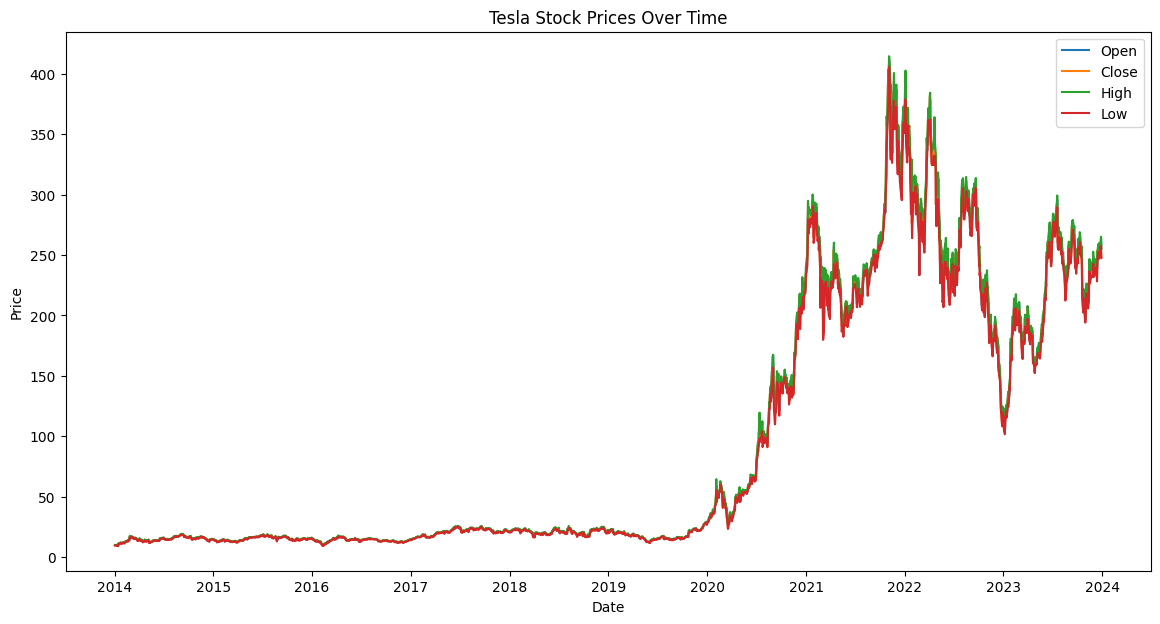

In [17]:
# Stock Price Trends Over Time

plt.figure(figsize=(14, 7))
plt.plot(df.index, df['open'], label='Open')
plt.plot(df.index, df['close'], label='Close')
plt.plot(df.index, df['high'], label='High')
plt.plot(df.index, df['low'], label='Low')
plt.title('Tesla Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


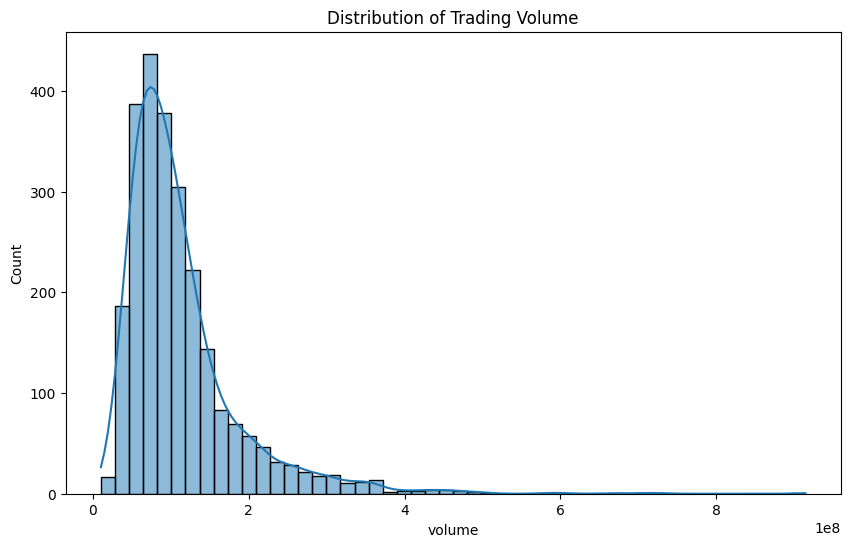

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


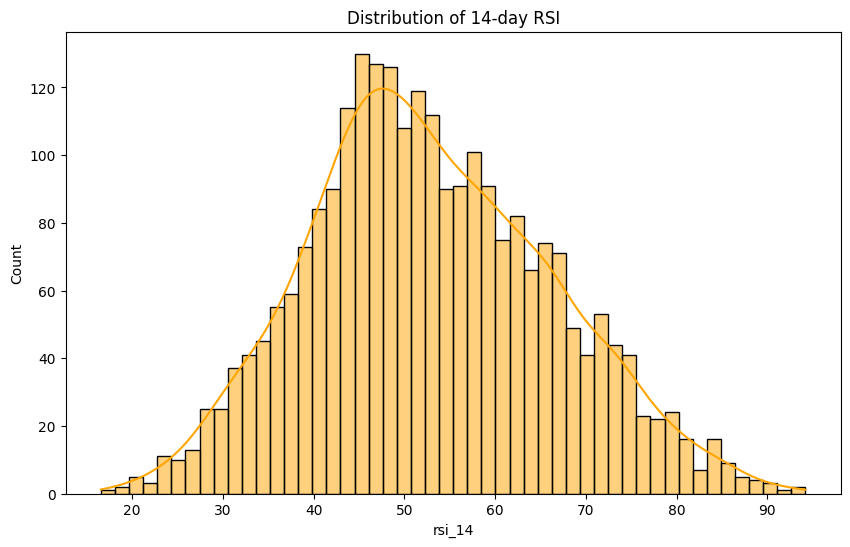

In [19]:
import seaborn as sns

# Distributions of Trading Volume and Technical Indicators

# Distribution of trading volume
plt.figure(figsize=(10, 6))
sns.histplot(df['volume'], kde=True, bins=50)
plt.title('Distribution of Trading Volume')
plt.show()

# Example: Distribution of RSI_14
plt.figure(figsize=(10, 6))
sns.histplot(df['rsi_14'], kde=True, bins=50, color='orange')
plt.title('Distribution of 14-day RSI')
plt.show()

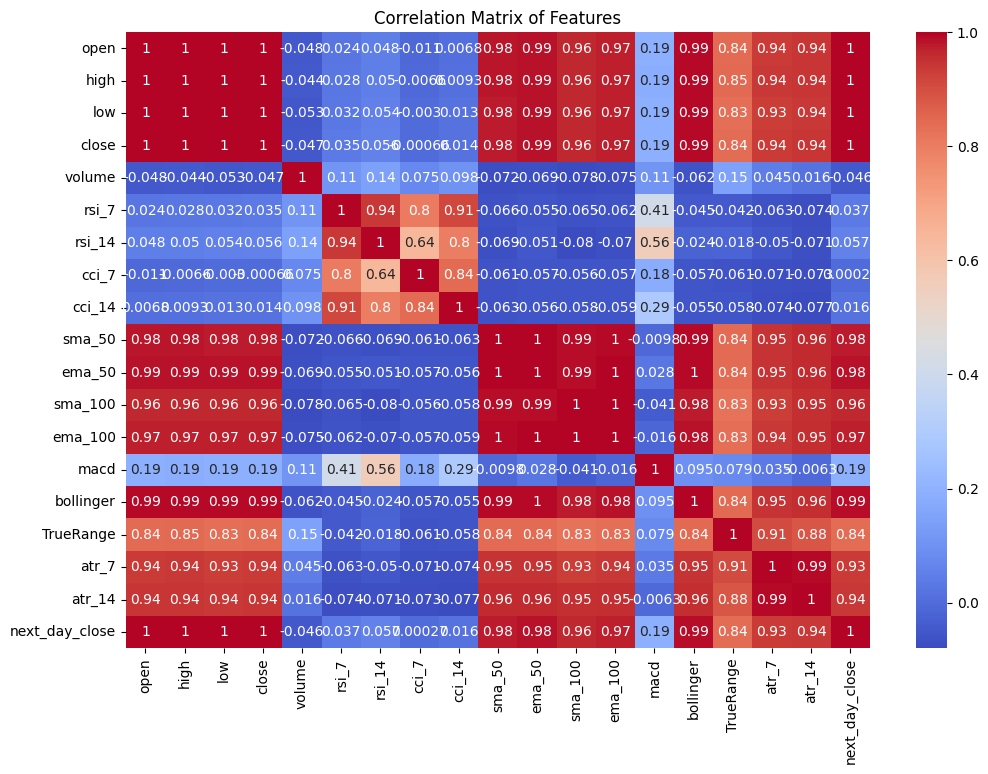

In [22]:
# Correlation Analysis

correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

In [24]:
# Create Time-Based Features

df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['year'] = df.index.year

# Optionally, convert day_of_week and month to categorical
df['day_of_week'] = df['day_of_week'].astype('category')
df['month'] = df['month'].astype('category')

In [25]:
# feature scaling

from sklearn.preprocessing import MinMaxScaler

# Assuming you've identified the features you want to scale
features_to_scale = ['open', 'high', 'low', 'close', 'volume']
scaler = MinMaxScaler()

df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

Machine Learning - Predictive

In [33]:
# Split the dataset into features (X) and target variable (y)
X = df.drop('next_day_close', axis=1)
y = df['next_day_close']

In [34]:
X.head(), y.head()

(                open      high       low     close    volume      rsi_7  \
 date                                                                      
 2014-01-02  0.001542  0.000903  0.001661  0.001790  0.090990  55.344071   
 2014-01-03  0.001575  0.000855  0.002006  0.001700  0.066195  53.742629   
 2014-01-06  0.001575  0.000560  0.001441  0.001274  0.077254  46.328174   
 2014-01-07  0.001180  0.000560  0.001442  0.001667  0.071825  53.263037   
 2014-01-08  0.001384  0.001104  0.002033  0.001987  0.090572  58.368660   
 
                rsi_14       cci_7     cci_14    sma_50  ...  month_3  month_4  \
 date                                                    ...                     
 2014-01-02  54.440118  -37.373644  15.213422  9.682107  ...    False    False   
 2014-01-03  53.821521  -81.304471  17.481130  9.652800  ...    False    False   
 2014-01-06  50.870410 -123.427544 -37.824708  9.629467  ...    False    False   
 2014-01-07  53.406750  -84.784651 -20.779431  9.597747 

The model building and training

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Shapes of the training and testing sets
X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape

((2012, 36), (504, 36), (2012,), (504,))

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the model architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1) # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100, batch_size=32, verbose=0)

# Evaluate the model on the test set
test_loss = model.evaluate(X_test_scaled, y_test, verbose=0)
print("Test Loss:", test_loss)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss: 57.057621002197266


calculate and print the RMSE for both training and testing sets

In [41]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predictions
train_predictions = model.predict(X_train_scaled)
test_predictions = model.predict(X_test_scaled)

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train RMSE: 5.204513393284837
Test RMSE: 7.583919879824593


Hyperparameter search with Keras Tuner's RandomSearch

In [53]:
import numpy as np
from tensorflow import keras
from kerastuner.tuners import RandomSearch
from keras_tuner import RandomSearch

In [54]:
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                                 activation='relu',
                                 input_shape=(X_train.shape[1],)))
    model.add(keras.layers.Dense(1))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='mean_squared_error')
    return model

convert a NumPy array to a Tensor

In [57]:
print(X_train.dtypes)

open             float64
high             float64
low              float64
close            float64
volume           float64
rsi_7            float64
rsi_14           float64
cci_7            float64
cci_14           float64
sma_50           float64
ema_50           float64
sma_100          float64
ema_100          float64
macd             float64
bollinger        float64
TrueRange        float64
atr_7            float64
atr_14           float64
year               int32
day_of_week_0       bool
day_of_week_1       bool
day_of_week_2       bool
day_of_week_3       bool
day_of_week_4       bool
month_1             bool
month_2             bool
month_3             bool
month_4             bool
month_5             bool
month_6             bool
month_7             bool
month_8             bool
month_9             bool
month_10            bool
month_11            bool
month_12            bool
dtype: object


In [58]:
# If using NumPy
X_train = X_train.astype('float32')

# If using Pandas
X_train = X_train.apply(pd.to_numeric)

# Check for NaN values
print(X_train.isnull().sum())

# Replace NaN values with 0 or an appropriate value
X_train.fillna(0, inplace=True)

# Check for infinite values
print(np.isinf(X_train).sum())

# Replace infinite values
X_train.replace([np.inf, -np.inf], 0, inplace=True)

open             0
high             0
low              0
close            0
volume           0
rsi_7            0
rsi_14           0
cci_7            0
cci_14           0
sma_50           0
ema_50           0
sma_100          0
ema_100          0
macd             0
bollinger        0
TrueRange        0
atr_7            0
atr_14           0
year             0
day_of_week_0    0
day_of_week_1    0
day_of_week_2    0
day_of_week_3    0
day_of_week_4    0
month_1          0
month_2          0
month_3          0
month_4          0
month_5          0
month_6          0
month_7          0
month_8          0
month_9          0
month_10         0
month_11         0
month_12         0
dtype: int64
open             0
high             0
low              0
close            0
volume           0
rsi_7            0
rsi_14           0
cci_7            0
cci_14           0
sma_50           0
ema_50           0
sma_100          0
ema_100          0
macd             0
bollinger        0
TrueRange        0

In [59]:
X_train = np.array(X_train).astype('float32')

In [60]:
# Ensure no NaN or Inf values remain
assert not np.isnan(X_train).any(), "X_train contains NaN values."
assert not np.isinf(X_train).any(), "X_train contains infinite values."

# If using TensorFlow's Dataset API
import tensorflow as tf
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

Initialize the Tuner and Start the Search

In [62]:
tuner = RandomSearch(build_model,
                     objective='val_loss',
                     max_trials=5,
                     executions_per_trial=3,
                     directory='my_dir',
                     project_name='hptuning')

tuner.search(X_train, y_train, epochs=20, validation_split=0.3)

Trial 5 Complete [00h 00m 18s]
val_loss: 186.55219523111978

Best val_loss So Far: 31.692135492960613
Total elapsed time: 00h 08m 48s
